# Part I: Fundamentals of NLP

## **Topic Modelling**

**Definition of topic modelling**:  

Automatically finding topics in documents using Latent Dirichlet Allocation.  

Natural Language Processing  

Author: D.Thébault

Referenced used:

- https://nlpdemystified.org

- https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/5_topicmodel_summ/Lad-Gibbs-lecture032321.pdf  


## Latent Dirichlet Allocation

[LDA](https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/5_topicmodel_summ/Lad-Gibbs-lecture032321.pdf)

The algorithm:  

From a Theorical and Practical Implementation Tutorial on Topic Modelling and Gibbs Sampling (2003) William M.Darling.  

**The generative process for a document collection D under the LDA model is as follows**:

1. For $k = 1, \ldots ,K$  
    - $\phi^{(k)} \sim Dirichlet(\beta) \; \Leftarrow$ word distribution for the topic $k$  

2. For each $d = 1, \ldots, D:$  
    - $\theta_d \sim Dirichlet(\alpha) \; \Leftarrow$ topic distribution for the document $d$  
    - For each $w_i \in d:$  
        i. $z_i \sim Discrete(\theta_d)\; \Leftarrow$ we sample a topic which the word should be in (maxim. proba)     
        ii. $w_i \sim Discrete(\phi^{(z_i)}) \Leftarrow$ we sample a word which comes from the topic $z_i$  

The hyperparameters $\alpha$ and $\beta$ are known as the Dirichlet priors. They are the hypothesis.  

They regularize the process avoiding the topics to become too specific or too general.  

- $\alpha$ controls the concentration of topics in each document.  
- $\beta$ controls the concentration of words in each topic.  

The algorithm converges through a stable distribution of the topics.  

## LDA Machine

In this jupyter notebook we will detail how to build a **Latent Dirichlet Allocation machine** as describe below.  

This LDA machine generates a corpus of documents.

### Steps to generate a document in a LDA model

1. **Distributions topics generation for every document ($\theta$) :**
   - For every document $d$, we sample a topic distribution $\theta_d$ from the Dirichlet distribution with parameter $\alpha$.
   $\theta_d \sim \text{Dirichlet}(\alpha)$

2. **Distributions words generation for every topic ($\phi$) :**
   - For every topic $k$, owe sample a word distribution $\phi_k$ from the Dirichlet distribution with parameter $\beta$.
  $\phi_k \sim \text{Dirichlet}(\beta)$

3. **Generation of topics for every word in every document ($z$) :**
   - For every word $w_{dn}$ in the document $d$, we sample a topic $z_{dn}$ from the topic distribution $\theta_d$.
   $z_{dn} \sim \text{Multinomial}(\theta_d)$

4. **Generation of words from topics ($w$) :**
   - For every word $w_{dn}$ in the document $d$, we sample a word $w_{dn}$ from the word distribution $\phi_{z_{dn}}$ associated to the topic $z_{dn}$.
   $w_{dn} \sim \text{Multinomial}(\phi_{z_{dn}})$

We will create more and more sophisticated versions of LDA from version 1 untill we get the final one version 5 which correspond to the steps describe below.

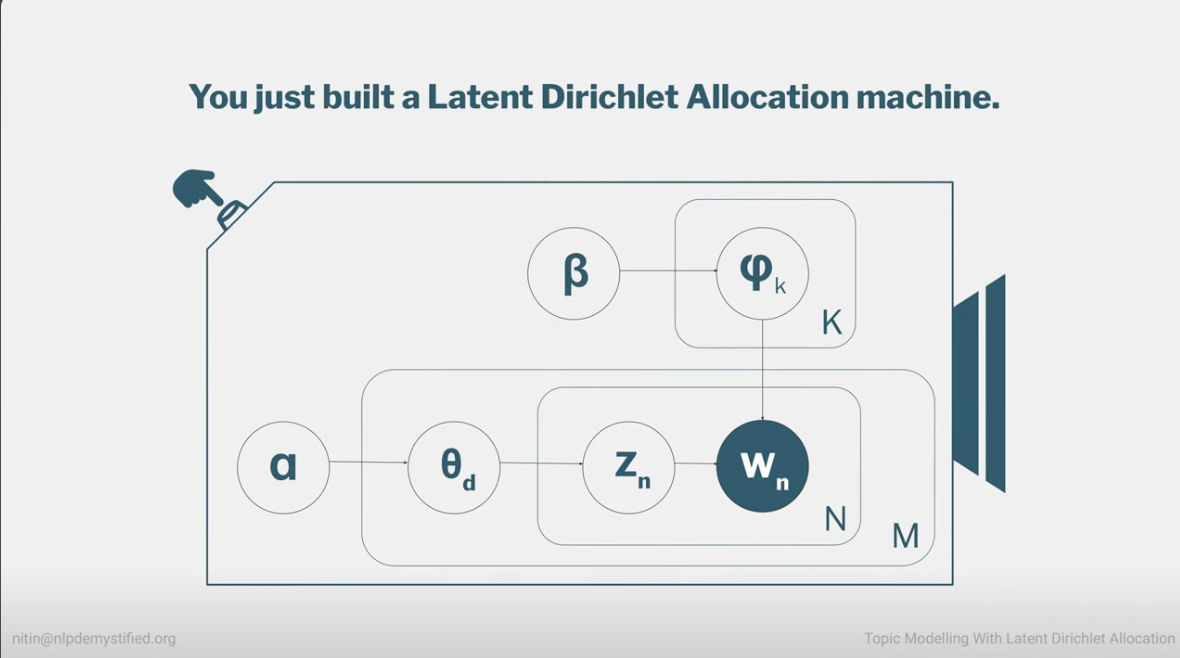

In [3]:
display.Image(r"./png/LDA_V0.png")

In [145]:
import numpy as np
import spacy
import pandas as pd
from tqdm import tqdm
from collections import Counter
import random
# from random import random

In [146]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the corpus
corpus = fetch_20newsgroups(categories=['sci.space'],remove=('headers', 'footers', 'quotes'))

In [216]:
# configuration of the numpy arrays to avoid scientific outputs
np.set_printoptions(suppress=True, precision=4)

#### **VERSION 1**

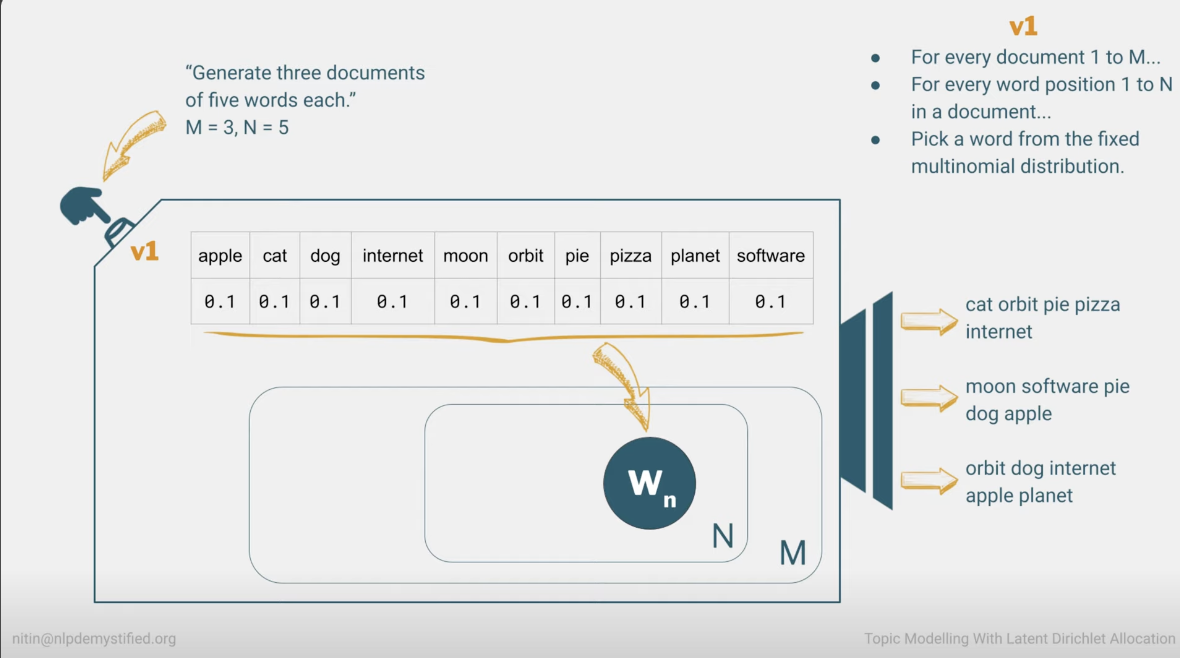

In [5]:
display.Image(r"./png/LDA_V1.png")

Words are uniformly distributed.  
Realize a machine that generates M documents of N words each using the vocabulary vocab

In [147]:
# Solution to version 1

# Vocabulary:
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']

# Transform the vocabulary into a dictionary in order to sample the words:
dico = {i: elem for i,elem in enumerate(vocab)}

# Generate M documents of N words
M = 3
N = 5

doc = []
for _ in range(M):
    for _ in range(N):
        doc.append(dico[random.randint(0,9)])
    print(doc)
    doc = []

['pizza', 'apple', 'dog', 'planet', 'software']
['orbit', 'cat', 'pizza', 'cat', 'planet']
['pizza', 'apple', 'dog', 'pie', 'dog']


In [161]:
# Improved solution to version 1

# Vocabulary:
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']

# Simplification using random.choices
M = 3
N = 5

# Generate M documents of N words
for _ in range(M):
    print(random.choices(vocab, k=N))

['orbit', 'software', 'moon', 'planet', 'planet']
['software', 'apple', 'pie', 'apple', 'pizza']
['software', 'orbit', 'pie', 'internet', 'software']


#### **VERSION 2**

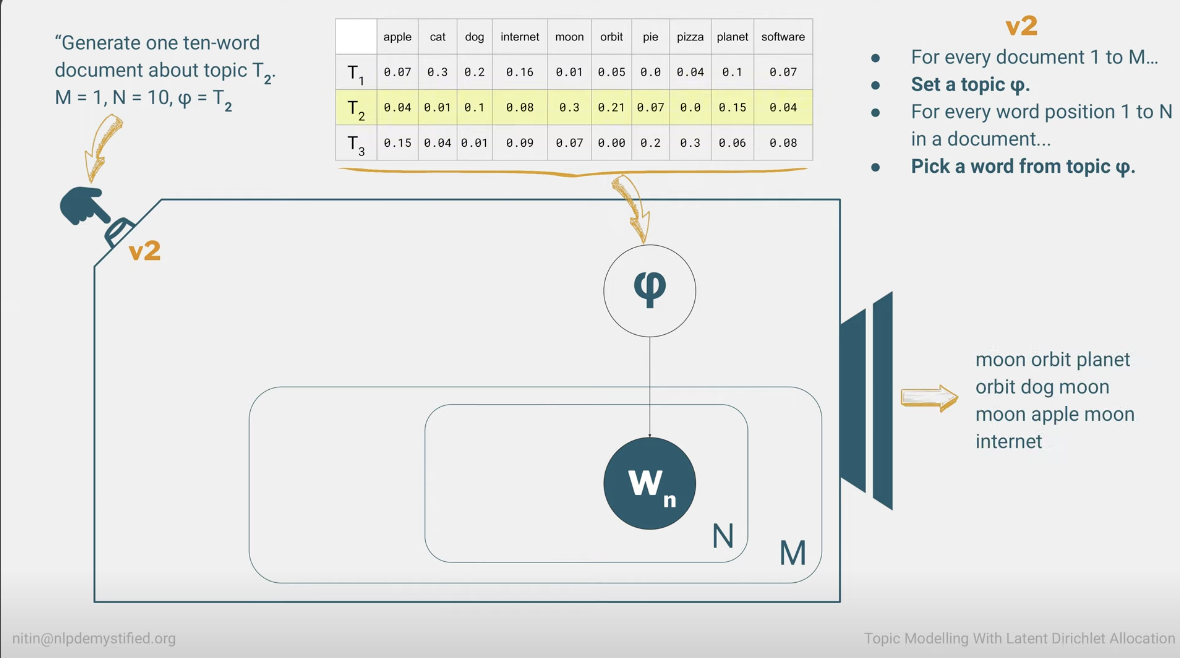

In [7]:
display.Image(r"./png/LDA_V2.png")

**This times, words are distributed depending on each of the 3 topics:**  
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']  
- p1 = [0.07, 0.3, 0.2, 0.16, 0.01, 0.05, 0.0, 0.04, 0.1, 0.07]   # Topic 1  
- p2 = [0.04, 0.01, 0.1, 0.08, 0.3, 0.21, 0.07, 0.0, 0.15, 0.04]  # Topic 2  
- p3 = [0.15, 0.04, 0.01, 0.09, 0.07, 0.00, 0.2, 0.3, 0.06, 0.08] # Topic 3 

In [162]:
# Vocabulary:
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']

# Parameters of the multinomial distribution
# Words distribution per topic 1,2 and 3
T1 = [0.07, 0.3, 0.2, 0.16, 0.01, 0.05, 0.0, 0.04, 0.1, 0.07]
T2 = [0.04, 0.01, 0.1, 0.08, 0.3, 0.21, 0.07, 0.0, 0.15, 0.04]
T3 = [0.15, 0.04, 0.01, 0.09, 0.07, 0.00, 0.2, 0.3, 0.06, 0.08]

# Set a topic
phi = [T1, T2, T3]

# Generate M documents of N words
M = 3
N = 8

# First we need to sample the topic \phi
for i in range(M):
    # we select the topic (the corresponding words distribution)
    T = phi[random.randint(0,2)]
    # We generate the corresponding N words documents
    print(random.choices(vocab, weights=T, k=N))

['moon', 'moon', 'orbit', 'pie', 'orbit', 'dog', 'dog', 'orbit']
['moon', 'planet', 'software', 'orbit', 'internet', 'dog', 'orbit', 'planet']
['software', 'orbit', 'moon', 'orbit', 'planet', 'moon', 'moon', 'pie']


#### **VERSION 3**

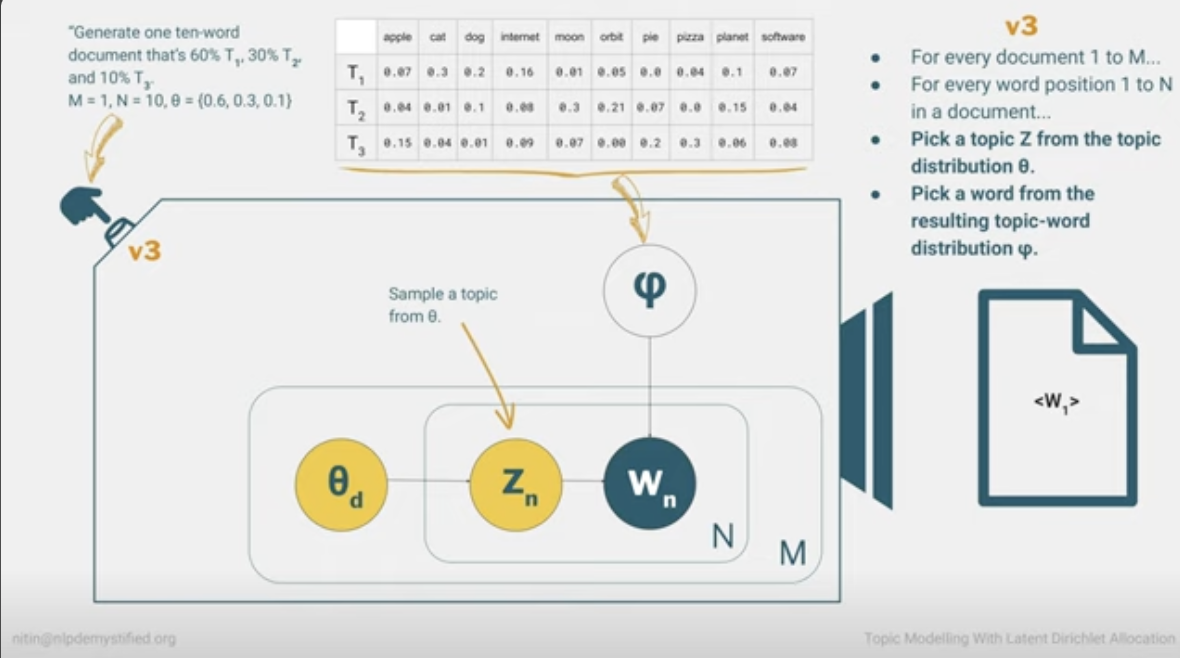

In [ ]:
display.Image(r"./png/LDA_V3.png")

Words are distributed depending on each of the 3 topics:  
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']  
- p1 = [0.07, 0.3 , 0.2 , 0.16, 0.01, 0.05, 0.0 , 0.04, 0.1 , 0.07]   # Topic 1  
- p2 = [0.04, 0.01, 0.1 , 0.08, 0.3 , 0.21, 0.07, 0.0 , 0.15, 0.04]  # Topic 2  
- p3 = [0.15, 0.04, 0.01, 0.09, 0.07, 0.00, 0.2 , 0.3 , 0.06, 0.08] # Topic 3  

But now, each topic as its own distribution \theta, **60% change for Topic 1, 30% for Topic 2 and 10% for Topic 3**.  

So the machine will:
- Pick a topic Z from the topic distribution \theta
- Pick a word from the resulting topic-word distribution \phi
- and do these two steps again to reach the total number of words of the document.

In [174]:
# Vocabulary:
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']

# Generate M documents of N words
M = 4  # number of documents
N = 5 # number of words of the document

# Parameters of the multinomial distribution
# Words distribution per topic 1,2 and 3
T1 = [0.07, 0.3, 0.2, 0.16, 0.01, 0.05, 0.0, 0.04, 0.1, 0.07]
T2 = [0.04, 0.01, 0.1, 0.08, 0.3, 0.21, 0.07, 0.0, 0.15, 0.04]
T3 = [0.15, 0.04, 0.01, 0.09, 0.07, 0.00, 0.2, 0.3, 0.06, 0.08]

# Set a topic
phi = [T1, T2, T3]

# The topic mix
theta = [0.6, 0.3, 0.1]

doc = []

for i in range(M):
    for j in range(N):
        # we pick a topic (the corresponding words distribution)
        z = random.choices(phi, weights=theta, k=1)[0]
        # We generate the corresponding N words documents
        doc.append(random.choices(vocab, weights=z, k=1)[0])
    print(doc)
    doc = []

['moon', 'internet', 'dog', 'dog', 'moon']
['pizza', 'software', 'pizza', 'software', 'internet']
['dog', 'cat', 'dog', 'internet', 'cat']
['internet', 'pizza', 'cat', 'orbit', 'moon']


Each document is now a distribution over topics, and each topic is a distribution over words.

#### **VERSION 4**

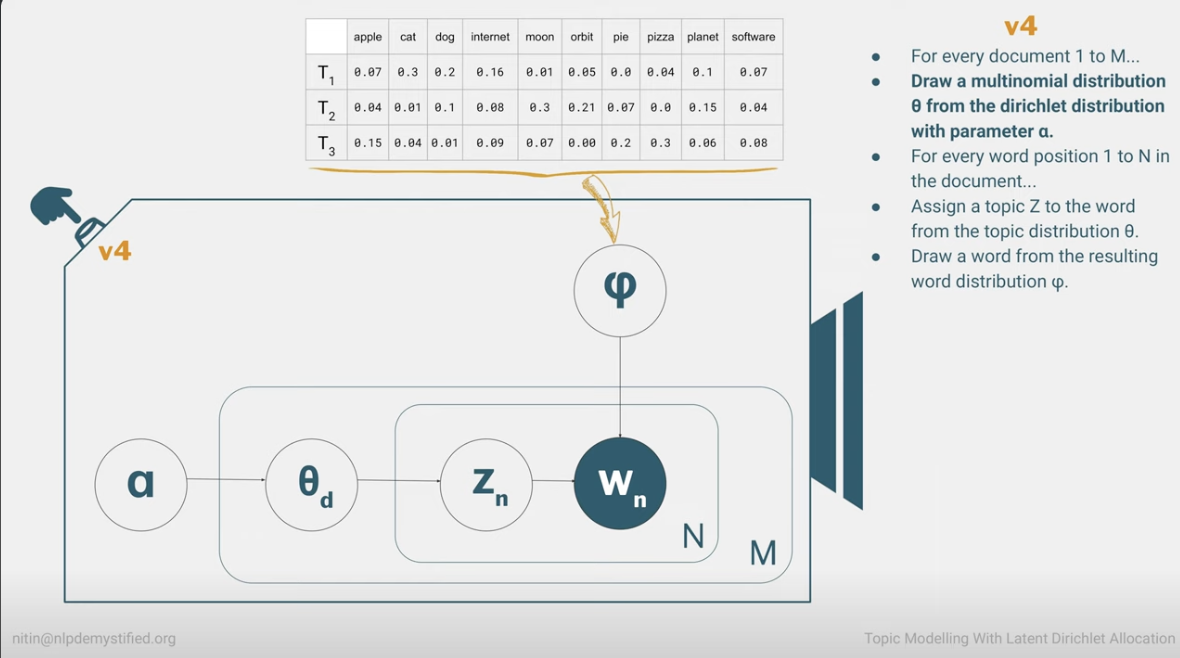

In [10]:
display.Image(r"./png/LDA_V4.png")

From version 4 we want to get away from specifying manually the per document topic distribution $\theta$.  
Instead we want the machine to generate this multinomial distribution denoted with $\alpha$.  
We need to talk about sampling multinomial distribution (**Dirichlet**)


**Dirichlet Distribution**  

Probability Density Function:  

The Dirichlet gives a distribution of all the places where a multinomial distribution can land.  

$Dir(\theta \; | \; \alpha) = \dfrac{1}{Beta(\alpha)}\prod_{i=1}^{i=K}\theta_k^{\alpha_k-1}$  

With $\theta_k$ the topics, $K$ their number, $0 < \alpha_k < 1$. We simplify with $\forall k, \alpha_k = \alpha$  

If we have 3 topics representing by a triangle where each sommet is a topic,  
words will be distributed by the Dirichlet distribution inside this triangle as follow:  
- $\alpha < 1$ will distribute the words close to the sommets
- $\alpha = 1$ will distribute the words uniformly
- $\alpha > 1$ will concentrate the words at the center of the triangle.

In [187]:
# Parameters
M = 3  # Number of documents
K = 3  # Number of dimensions (topics)
C = 0.75  # unique alpha parameter

# create a vector alpha repeating the parameter alpha K times
alpha = np.full(K, C)
alpha

array([0.75, 0.75, 0.75])

In [203]:
alpha = 1.0  # unique alpha parameter
N = 4  # Number of words

# thetas is a list with N Dirichlet distribution:
thetas = []
for _ in range(3):
    theta = np.random.dirichlet(np.random.dirichlet(np.full(N, alpha)))
    thetas.append(theta)

for i, theta in enumerate(thetas):
    print(f"Document {i+1}: {theta}")

Document 1: [1.62831246e-09 3.30617850e-01 7.32468503e-03 6.62057463e-01]
Document 2: [7.65440631e-01 2.15402635e-16 1.58328302e-02 2.18726539e-01]
Document 3: [0.33415886 0.02286336 0.35508892 0.28788887]


In [254]:
# Vocabulary:
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']

# Generate M documents of N words
M = 4  # number of documents
N = 5 # number of words of the document
K = 3 # number of topics

alpha = 1.0 # alpha parameter

doc = [] # the generated document
for i in range(M):
    for j in range(N):
        # we pick a topic (the corresponding words distribution)
        phi = []
        for _ in range(K):
            # word distribution per topic (phi the global word-topic distribution)
            p = np.random.dirichlet(np.random.dirichlet(np.full(len(vocab), alpha)))
            phi.append(p)
        theta = [0.6, 0.3, 0.1]
        z = random.choices(phi, weights=theta, k=1)[0]
        w_n = random.choices(vocab, weights=z, k=1)[0]
        # We generate the corresponding N words documents
        doc.append(w_n)
    print(doc)
    doc = []

['orbit', 'internet', 'apple', 'planet', 'internet']
['planet', 'pie', 'pie', 'internet', 'planet']
['apple', 'software', 'software', 'dog', 'pie']
['cat', 'software', 'pie', 'software', 'software']


#### **VERSION 5**

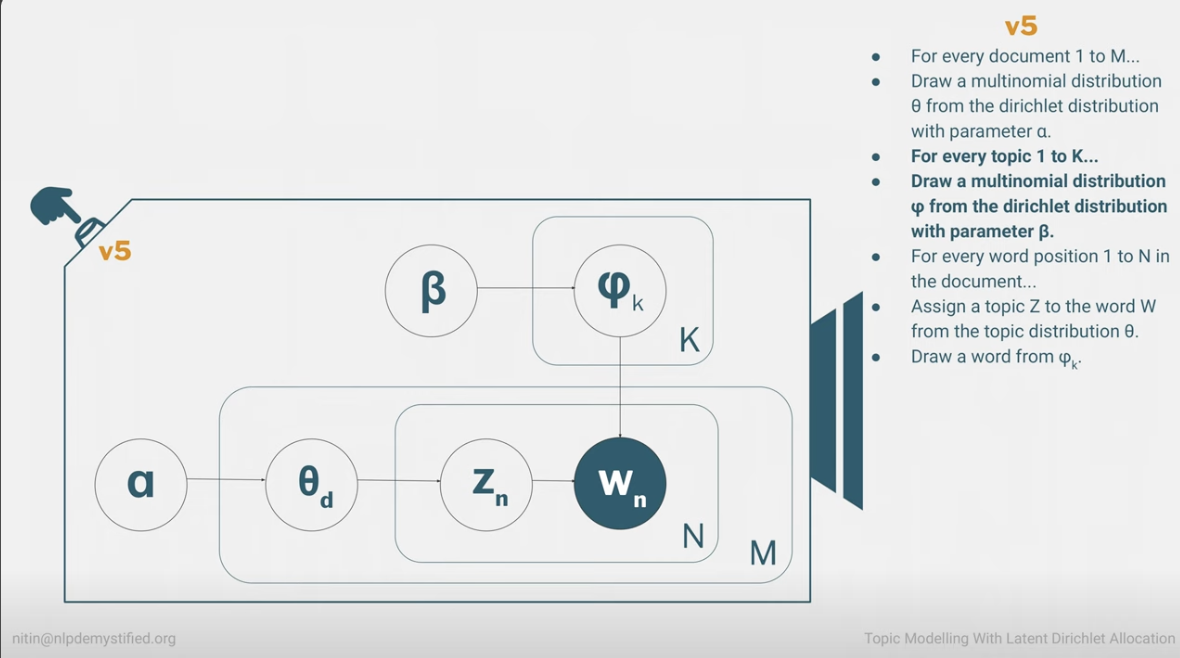

In [11]:
display.Image(r"./png/LDA_V5.png")

#### **Latent Dirichlet Allocation (LDA) machine**

From version 5 we want to get away from specifying manually the per topic word distribution $\phi$.  
Instead we will plug another Dirichlet distribution $\beta$.  

In [265]:
# Vocabulary:
vocab = ['apple', 'cat', 'dog', 'internet', 'moon', 'orbit', 'pie', 'pizza', 'planet', 'software']

# Generate M documents of N words
M = 4  # number of documents
N = 5 # number of words of the document
K = 3 # number of topics

alpha = 1.0 # alpha parameter
beta = 0.5 # beta parameter

doc = [] # the generated document
for i in range(M):
    for j in range(N):
        # we pick a topic (the corresponding words distribution)
        phi = []
        for _ in range(K):
            # word distribution per topic (phi the global word-topic distribution)
            p = np.random.dirichlet(np.random.dirichlet(np.full(len(vocab), alpha)))
            phi.append(p)
        # Dirichlet for topic distribution:
        beta_vector = np.full(K, beta)
        theta = np.random.dirichlet(beta_vector)
        z = random.choices(phi, weights=theta, k=1)[0]
        w_n = random.choices(vocab, weights=z, k=1)[0]
        # We generate the corresponding N words documents
        doc.append(w_n)
    print(doc)
    doc = []

['orbit', 'moon', 'apple', 'planet', 'apple']
['moon', 'moon', 'pizza', 'cat', 'pizza']
['moon', 'apple', 'pizza', 'software', 'pizza']
['apple', 'internet', 'software', 'moon', 'orbit']


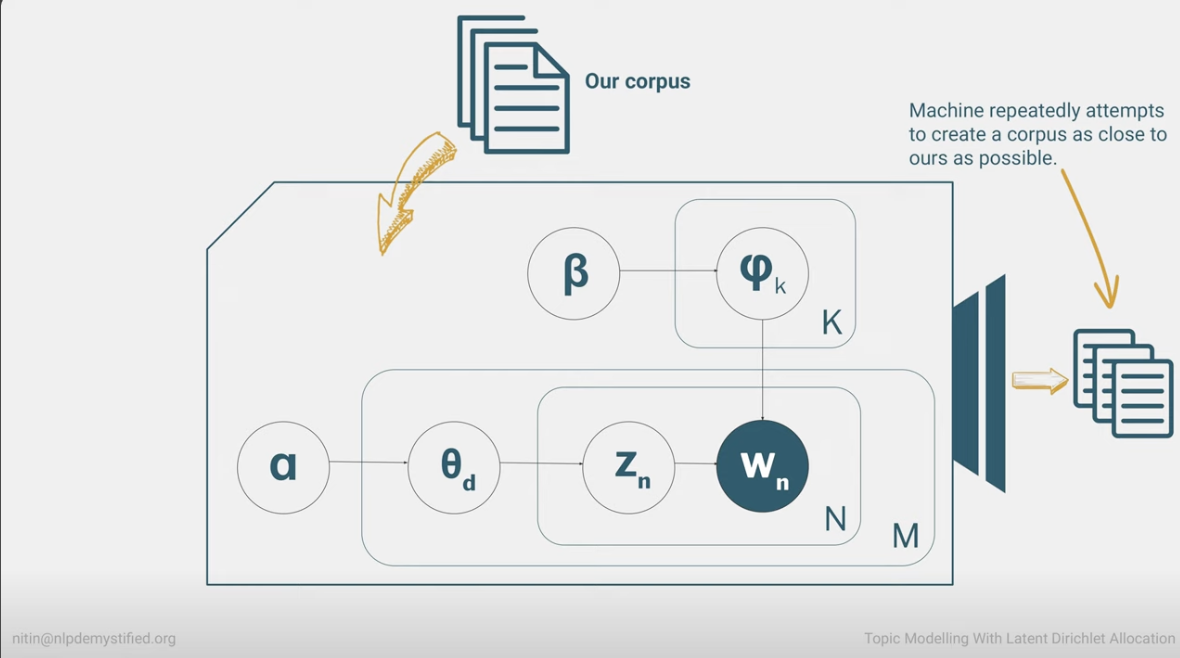

In [12]:
display.Image(r"./png/LDA_V6.png")

This is a Probabilistic Graphical Model (PGM). The arrows represent the dependance.

The goal is to train our LDA machine to fit our latent variables $\alpha$ and $\beta$ to generate a corpus as close to ours as possible.

We will have then the corpus adapted:
- per document topic distributions $\theta$ and 
- per topic word distribution $\phi$.  

We use the machine to reverse engineer our corpus.

## Apendices